# Step 1: Read in the Data and Packages

Packages

In [1]:
# General
import pandas as pd
import numpy as np
from nltk import word_tokenize
import re
from string import punctuation 
from nltk.corpus import stopwords
import nltk 
#nltk.download('wordnet') # Downloads the WordNetLemmatizer package
from nltk.stem import WordNetLemmatizer 
import re

#Word Cloud
from os import path
from PIL import Image
import wordcloud
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

# Oversample
from sklearn.utils import resample
import dataframe_image as dfi

# Train Test Split
from sklearn.model_selection import train_test_split

#Models and Performance Metrics
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score,precision_score,recall_score,classification_report
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import svm
sns.set() 

# Neural Networks
import torch
import torchtext
from torchtext.legacy import data #For handling text data
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F


The Dataset being used is the COVID-19 Rumours Dataset (Cheng, M., Wang, S., Yan, X., Yang, T., Wang, W., Huang, Z., Xiao, X., Nazarian, S., & Bogdan, P. (2021). A COVID-19 Rumor Dataset. Frontiers in Psychology, 12. https://doi.org/10.3389/fpsyg.2021.644801)

In [2]:
url = 'https://raw.githubusercontent.com/MickeysClubhouse/COVID-19-rumor-dataset/master/Data/en_dup.csv'
df = pd.read_csv(url)
df = df.drop(columns=['source', 'author', 'time',])
df.rename(columns={'label': 'veracity', 'content': 'text'}, inplace=True)
df

,veracity,text
0,F,Coronavirus was created in a government lab as...
1,F,The lie that coronavirus came from a bat or a ...
2,F,The health experts had predicted the virus cou...
3,F,A video clip supposedly showed that the expone...
4,T,Almost 200 people in Italy died from the coron...
...,...,...
7174,F,“DDP (Democratic Progressive Party) legislator...
7175,F,"In Japan, if the new coronavirus test is negat..."
7176,T,We have a perfectly coordinated and fine tuned...
7177,F,Official death toll over 900 but we all know t...


Save to CSV for future reference

In [3]:
#df.to_csv('Covid Rumours.csv', index=False)

Relabel Sentiment to true, false and unverified

In [4]:
df['veracity'] = df['veracity'].map({"F":"False","T":"True", "U":"Unverified"})

Check Class distributions

In [5]:
print("The Percentage of classes are:")
print(df['veracity'].value_counts(normalize=True).mul(100).round(1).astype(str) + '%')
print("\n")
print("The Number of classes are:")
print(df['veracity'].value_counts())

The Percentage of classes are:
False         51.3%
True          26.2%
Unverified    22.6%
Name: veracity, dtype: object


The Number of classes are:
False         3681
True          1878
Unverified    1620
Name: veracity, dtype: int64


# Step 2: PreProcess the Data

Split X (text) and Y (veracity)

In [6]:
veracity = df["veracity"].tolist()
text = df["text"].tolist()
print(len(veracity))
print(len(text))

7179
7179


1: Remove stopwords, lowercase and tokenize

In [7]:
stopwords_english = stopwords.words('english') 

In [8]:
# Adding Extra words to the stopoword corpus
f = "say"
stopwords_english.append(f)
l = "get"
stopwords_english.append(l)

In [9]:
veracity_token = []
text_token = []

#Printing the 7th text out to see changed in processes. Here this is 
# the text before preprocessing
print("Text 1:", text[7])
print("Veracity 1:", veracity[7])

Text 1: The Centers for Disease Control and Prevention (CDC) announced that COVID-19, a disease caused by the coronavirus, had been found in toilet paper, and that people should use wet cloths instead
Veracity 1: False


In [10]:
print("Tokenising text...", end="")
for i in range(len(text)):
    try:
        tokens = word_tokenize(text[i].lower())#break up sentence to individual words
        stopwords_removed = [k for k in tokens if k not in stopwords_english]
        if(len(stopwords_removed)>1):  
            text_token.append(stopwords_removed) 
            veracity_token.append(veracity[i])
    except:
        pass
print("[COMPLETED]\n") #Use this to see when command is completed.

Tokenising text...[COMPLETED]



In [11]:
print("Total text:", len(text_token))
print("Total labels:", len(veracity_token))
print("Text 1:", text_token[7])
print("Veracity 1:", veracity_token[7])

Total text: 7177
Total labels: 7177
Text 1: ['centers', 'disease', 'control', 'prevention', '(', 'cdc', ')', 'announced', 'covid-19', ',', 'disease', 'caused', 'coronavirus', ',', 'found', 'toilet', 'paper', ',', 'people', 'use', 'wet', 'cloths', 'instead']
Veracity 1: False


2: Remove Punctuation and empty elemtns. COVID-19 is replaced with covidnineteen to keep it original later

In [12]:
text_preprocessed = text_token #copy

In [13]:
print("Preprocessing test reviews..",end="")
for i in range(len(text_token)):
    new_tokens = []
    for word in text_token[i]:
        word = word.replace("covid-19", "covidnineteen")
        word = word.replace("5g", "fiveg")
        word = word.replace("-", " ") 
        word = word.replace(".", " ")
        word = word.replace("!", " ") 
        word = word.replace("https", " ") 
        word = word.replace("wasn t ", "was not")
        word = word.replace(" s", " ") 
        reg_exp = re.match("[a-z]+", word) #Only keep words a-z
        if(reg_exp!=None):
            if(reg_exp.group()==word):
                new_tokens.append(word)
    text_preprocessed[i] = new_tokens
print("[COMPLETED]\n")

# Check if pre-processing led to any empty tweets
for i in range(len(text_preprocessed)):
    if(len(text_preprocessed[i])==0):
        print("Text",i,"is empty. This needs to be removed!")
print(text_preprocessed[7])
        

Preprocessing test reviews..[DONE]

Text 1849 is empty. This needs to be removed!
['centers', 'disease', 'control', 'prevention', 'cdc', 'announced', 'covidnineteen', 'disease', 'caused', 'coronavirus', 'found', 'toilet', 'paper', 'people', 'use', 'wet', 'cloths', 'instead']


In [14]:
#Removing empty elements
text_pp = []
veracity_pp = []

for i in range(len(text_preprocessed)):
    if(len(text_preprocessed[i])>1):
        text_pp.append(text_preprocessed[i])
        veracity_pp.append(veracity_token[i])

In [15]:
# Check length as debugging 
print(len(text_pp))
print(len(veracity_pp))

7168
7168


3: Join together for Lemmatisation

In [16]:
sentence_final= []

for k in range(len(text_pp)):
    text = " ".join(text_pp[k])
    sentence_final.append(text)
print("Text number 7 :\n", sentence_final[7], "\n")

Text number 7 :
 centers disease control prevention cdc announced covidnineteen disease caused coronavirus found toilet paper people use wet cloths instead 



4: Lemmatisation 

In [17]:
wnl = WordNetLemmatizer()

In [18]:
# Returns vocab to verb form
sentence_final2 = [[wnl.lemmatize(word, pos='v') for word in sentence.split(" ")] for sentence in sentence_final]
print(sentence_final2[7])

['center', 'disease', 'control', 'prevention', 'cdc', 'announce', 'covidnineteen', 'disease', 'cause', 'coronavirus', 'find', 'toilet', 'paper', 'people', 'use', 'wet', 'cloths', 'instead']


5: Join together

In [19]:
for i in range(len(sentence_final2)):
    new_tokens = []
    for word in sentence_final2[i]:
        word = word.replace("covidnineteen", "covid-19")
        word = word.replace("fiveg", "five-g")
        new_tokens.append(word)
    sentence_final2[i] = new_tokens
print(sentence_final2[7])

['center', 'disease', 'control', 'prevention', 'cdc', 'announce', 'covid-19', 'disease', 'cause', 'coronavirus', 'find', 'toilet', 'paper', 'people', 'use', 'wet', 'cloths', 'instead']


In [20]:
# Join together
sentence_finals= []

for k in range(len(sentence_final2)):
    text = " ".join(sentence_final2[k])
    sentence_finals.append(text)
print("Text number 7 :\n", sentence_finals[7], "\n")

Text number 7 :
 center disease control prevention cdc announce covid-19 disease cause coronavirus find toilet paper people use wet cloths instead 



In [21]:
# Checking lengths for final debug
print("There are",len(sentence_finals), "texts")
print("There are",len(veracity_pp), "veracity labels")

There are 7168 texts
There are 7168 veracity labels


# Step 3: Prepare for Analysis 

In [22]:
data = pd.DataFrame({"Text":sentence_finals, "Veracity": veracity_pp})
data.to_csv('data 3 class.csv',index=False)
print(data.head())

                                                Text Veracity
0  coronavirus create government lab bioweapon re...    False
1  lie coronavirus come bat pangolin concoct chin...    False
2  health experts predict virus could kill millio...    False
3  video clip supposedly show exponential spread ...    False
4   almost people italy die coronavirus period march     True


# Analysis 1: Word cloud

In [23]:
# Start with loading all necessary libraries
import numpy as np
import pandas as pd
from os import path
from PIL import Image
import wordcloud
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt


In [24]:
truth = data[data.Veracity == "True"]
false = data[data.Veracity == "False"]
unverified = data[data.Veracity == "Unverified"]

In [25]:
truth = truth['Text']
false = false['Text']
unverified = unverified['Text']

In [26]:
truth = truth.values.tolist()
false = false.values.tolist()
unverified = unverified.values.tolist()

covid = ["coronavirus", "covid-19"]

In [27]:
truthWord = [word for line in truth for word in line.split()]
truthWord = [x for x in truthWord if x not in stopwords_english]
truthWord = [x for x in truthWord if x not in covid]

falseWord = [word for line in false for word in line.split()]
falseWord = [x for x in falseWord if x not in stopwords_english ]
falseWord = [x for x in falseWord if x not in covid]

unverifiedWord = [word for line in unverified for word in line.split()]
unverifiedWord = [x for x in unverifiedWord if x not in stopwords_english]
unverifiedWord = [x for x in unverifiedWord if x not in covid]

In [28]:
from collections import Counter
most_common_truth= [word for word, word_count in Counter(truthWord).most_common(20)]
most_common_false= [word for word, word_count in Counter(falseWord).most_common(20)]
most_common_unverified= [word for word, word_count in Counter(unverifiedWord).most_common(20)]


In [29]:
# Truth
truthCounts = []

for w in most_common_truth:
    wordCount =(w, truthWord.count(w)) #Counts
    truthCounts.append(wordCount) #Add to list
truthCounts.sort(key = lambda x : x[1], reverse = True) #Orders from most common
    
print("The top 20 most common words for truth:")
for wordCount in truthCounts:
    print(wordCount[0], wordCount[1]) #Print out 20 most common words and count
    
    
# False
print("\n")
falseCounts = []
for w in most_common_false:
    wordCount =(w, falseWord.count(w)) #Counts
    falseCounts.append(wordCount) #Add to list
falseCounts.sort(key = lambda x : x[1], reverse = True) #Orders from most common

print("The top 20 most common words for False:")
for wordCount in falseCounts:
    print(wordCount[0], wordCount[1]) #Print out 20 most common words and count
    
# Unverified
print("\n")
unverifiedCounts = []
for w in most_common_unverified:
    wordCount =(w, unverifiedWord.count(w)) #Counts
    unverifiedCounts.append(wordCount) #Add to list
unverifiedCounts.sort(key = lambda x : x[1], reverse = True) #Orders from most common
    
print("The top 20 most common words for Unverified:")
for wordCount in unverifiedCounts:
    print(wordCount[0], wordCount[1]) #Print out 20 most common words and count    
    

The top 20 most common words for truth:
china 322
wuhan 243
test 219
virus 219
people 218
case 193
outbreak 174
new 169
health 163
spread 152
cdc 115
state 112
positive 107
us 105
first 105
confirm 102
report 98
go 97
pandemic 94
make 84


The top 20 most common words for False:
people 420
china 371
virus 354
show 269
claim 261
wuhan 255
video 243
new 227
chinese 214
infect 196
novel 194
outbreak 181
test 181
spread 179
case 173
cure 167
kill 166
prevent 155
government 147
water 145


The top 20 most common words for Unverified:
china 535
wuhan 345
virus 214
people 210
chinese 160
outbreak 159
case 146
us 141
new 118
spread 106
health 91
trump 82
could 80
one 78
go 69
like 69
world 68
report 66
government 64
may 63


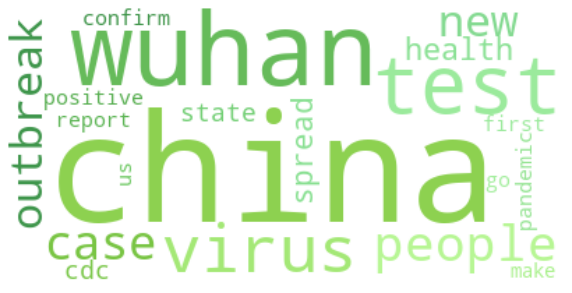

In [30]:
# Create word cloud
truth_dict=dict(truthCounts)
truth_dict
mask = np.array(Image.open("/Users/chloeneal/Durham University/Term 3 (Dissertation)/Data/green.jpeg"))
wordcloud_c = WordCloud(background_color="white").generate_from_frequencies(truth_dict)
image_colors = ImageColorGenerator(mask)
plt.figure(figsize=[10,8])
plt.imshow(wordcloud_c.recolor(color_func=image_colors), interpolation="bilinear")
plt.axis("off")

#plt.savefig("/Users/chloeneal/Durham University/Term 3 (Dissertation)/Data/true.png", format="png",bbox_inches='tight')

plt.show()




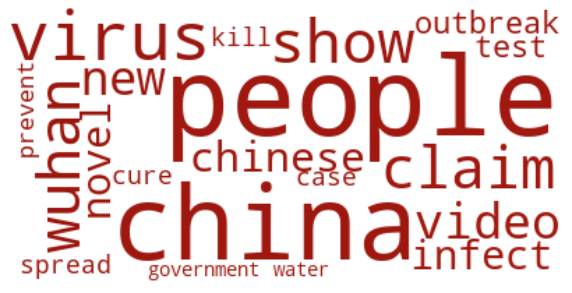

In [31]:
# Create word cloud
false_dict=dict(falseCounts)
false_dict
mask = np.array(Image.open("/Users/chloeneal/Durham University/Term 3 (Dissertation)/Data/red.jpeg"))
wordcloud_c = WordCloud(background_color="white").generate_from_frequencies(false_dict)
image_colors = ImageColorGenerator(mask)
plt.figure(figsize=[10,8])
plt.imshow(wordcloud_c.recolor(color_func=image_colors), interpolation="bilinear")
plt.axis("off")

#plt.savefig("/Users/chloeneal/Durham University/Term 3 (Dissertation)/Data/false.png", format="png",bbox_inches='tight')

plt.show()

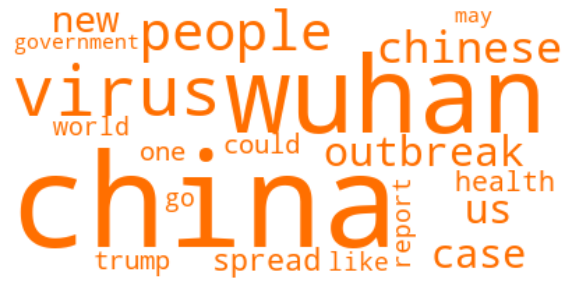

In [32]:
# Create word cloud
un_dict=dict(unverifiedCounts)
un_dict
mask = np.array(Image.open("/Users/chloeneal/Durham University/Term 3 (Dissertation)/Data/orange.jpeg"))
wordcloud_c = WordCloud(background_color="white").generate_from_frequencies(un_dict)
image_colors = ImageColorGenerator(mask)
plt.figure(figsize=[10,8])
plt.imshow(wordcloud_c.recolor(color_func=image_colors), interpolation="bilinear")
plt.axis("off")

#plt.savefig("/Users/chloeneal/Durham University/Term 3 (Dissertation)/Data/unverified.png", format="png",bbox_inches='tight')

plt.show()

# Analysis 2: Models

Split training and testing, 70% vs 30%

In [33]:
train, test = train_test_split(data, test_size = 0.3)

In [34]:
#Debugging
print("There are", len(train), "observations in the training set")
print("There are", len(test), "observations in the testing set")
print("\n")

There are 5017 observations in the training set
There are 2151 observations in the testing set




In [35]:
# Class distributions of training set
print("The Percentage of train classes are:")
print(train['Veracity'].value_counts(normalize=True).mul(100).round(1).astype(str) + '%')
print("\n")
print("The Number of train classes are:")
print(train['Veracity'].value_counts())

The Percentage of train classes are:
False         51.3%
True          26.2%
Unverified    22.5%
Name: Veracity, dtype: object


The Number of train classes are:
False         2573
True          1316
Unverified    1128
Name: Veracity, dtype: int64


In [36]:
print("The Percentage of test classes are:")
print(test['Veracity'].value_counts(normalize=True).mul(100).round(1).astype(str) + '%')
print("\n")
print("The Number of test classes are:")
print(test['Veracity'].value_counts())

The Percentage of test classes are:
False         51.3%
True          26.0%
Unverified    22.7%
Name: Veracity, dtype: object


The Number of test classes are:
False         1103
True           560
Unverified     488
Name: Veracity, dtype: int64


# Create Class distribution tables

In [37]:
import dataframe_image as dfi
class_dis2 = {}  
class_dis2= pd.DataFrame(columns = ["Classification", "Training Count", "Training Percentage", "Testing Count", "Testing Percentage"],
                         data = [["False", 2573, "51.3%", 1103, "51.3%"],
                                 ["True", 1316, "26.2%", 560, "26%"],
                                 ["Unverified", 1128, "22.5%", 488, "22.7%"]])
          
                                 
                                 
class_dis2.set_index('Classification', inplace=True)
class_dis2 

c2 = class_dis2.style.set_table_attributes("style='display:inline'").set_caption('Class Distribution of Training and Testing Set for Multi-class Analysis')
c2

#dfi.export(c2,"Training and Testing Distribution 3.png")


,Training Count,Training Percentage,Testing Count,Testing Percentage
Classification,,,,
False,2573,51.3%,1103,51.3%
True,1316,26.2%,560,26%
Unverified,1128,22.5%,488,22.7%


Text(0.5, 1.0, 'Graph of the Distribution of Classes in the Training and Testing Set for Multi-class Analysis')

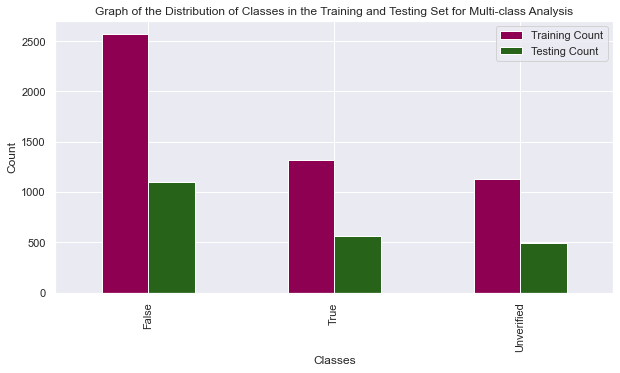

In [38]:
ax = class_dis2.plot.bar(figsize=[10,5],cmap='PiYG')
#ax.figure(figsize=[10,8])
ax.set_ylabel('Count')
ax.set_xlabel('Classes')
ax.set_title("Graph of the Distribution of Classes in the Training and Testing Set for Multi-class Analysis")
#ax.figure.savefig("Testgraph.png",transparent=False,bbox_inches='tight')


# Rebalance the Classes

In [39]:
df_majority = train[train['Veracity']=='False']
df_minority_true = train[train['Veracity']=='True']
df_minority_un =train[train['Veracity']=='Unverified']


In [40]:
df_minority_upsampled_un = resample(df_minority_un,
                                   replace = True,
                                   n_samples =  2573)

df_minority_upsampled_true = resample(df_minority_true,
                                   replace = True,
                                   n_samples =   2573)

In [41]:
df_upsampled = pd.concat([df_minority_upsampled_un, df_minority_upsampled_true,df_majority])

In [42]:
#Debugging
print("The Percentage of classes are:")
print(df_upsampled['Veracity'].value_counts(normalize=True).mul(100).round(1).astype(str) + '%')
print("\n")
print("The Number of classes are:")
print(df_upsampled['Veracity'].value_counts())

The Percentage of classes are:
False         33.3%
Unverified    33.3%
True          33.3%
Name: Veracity, dtype: object


The Number of classes are:
False         2573
Unverified    2573
True          2573
Name: Veracity, dtype: int64


In [43]:
train = df_upsampled

In [44]:
train_text = train["Text"].tolist()
train_veracity = train["Veracity"].tolist()

test_text = test["Text"].tolist()
test_veracity = test["Veracity"].tolist()

# Check lengths
print(len(train_text))
print(len(train_veracity))

print(len(test_text))
print(len(test_veracity))

7719
7719
2151
2151


# Step 5: Model Implementation 

# Model 1: Multinomial Naives Bayes

In [45]:
# This creates Tf-Idf Vector, then feeds into the multinomial naive bayes.
model1 = make_pipeline(TfidfVectorizer(), MultinomialNB())
model1.fit(train_text, train_veracity) # Train 

predicted_categories = model1.predict(test_text) # Predict 

print("Predicted Veracity:",predicted_categories.tolist()[0:5]) # First 5 predictions
print("Ground truth Veracity:",test_veracity[0:5],"\n") # First 5 ground truth values


Predicted Veracity: ['True', 'Unverified', 'False', 'False', 'False']
Ground truth Veracity: ['False', 'Unverified', 'False', 'False', 'False'] 



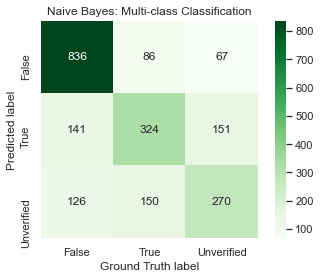

Accuracy:	0.664807
F1-score:	0.624166
Precision:	0.621926
Recall:		0.629928

 Classification performance:
              precision    recall  f1-score   support

       False       0.85      0.76      0.80      1103
        True       0.53      0.58      0.55       560
  Unverified       0.49      0.55      0.52       488

    accuracy                           0.66      2151
   macro avg       0.62      0.63      0.62      2151
weighted avg       0.68      0.66      0.67      2151



In [128]:
#Plot the confusion matrix 
mat1 = confusion_matrix(test_veracity, predicted_categories)
sns.heatmap(mat1.T, square = True, xticklabels = ["False","True","Unverified"], yticklabels = ["False","True","Unverified"],annot=True, fmt = "d",cmap="Greens")
plt.xlabel("Ground Truth label")
plt.ylabel("Predicted label")
plt.title("Naive Bayes: Multi-class Classification")
#plt.savefig("Model 1- Multinomial Naive Bayes 3 class.png")
plt.show()

# Compute and print classification performance metrics
print("Accuracy:\t%f" % accuracy_score(test_veracity, predicted_categories))
print("F1-score:\t%f" % f1_score(test_veracity, predicted_categories, average='macro'))
print("Precision:\t%f" % precision_score(test_veracity, predicted_categories, average='macro'))
print("Recall:\t\t%f" % recall_score(test_veracity, predicted_categories, average='macro'))

print("\n Classification performance:\n%s" % classification_report(test_veracity, predicted_categories))


# Model 2- K-Nearest Neighbour

In [47]:
# Creates numeric vector, feeds into KNN
model3 = make_pipeline(TfidfVectorizer(), KNeighborsClassifier(n_neighbors=29))
model3.fit(train_text, train_veracity) # Train

predicted_categories3 = model3.predict(test_text) # Predict

print("Predicted Veracity:",predicted_categories3.tolist()[0:5]) # First 5 predictions
print("Ground truth Veracity:",test_veracity[0:5],"\n") # First 5 ground truth values


Predicted Veracity: ['False', 'Unverified', 'False', 'False', 'False']
Ground truth Veracity: ['False', 'Unverified', 'False', 'False', 'False'] 



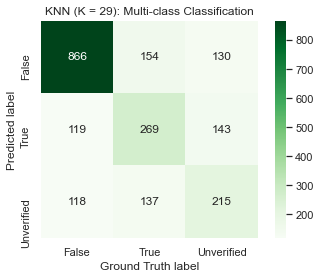

Accuracy:	0.627615
F1-score:	0.570243
Precision:	0.572361
Recall:		0.568687

 Classification performance:
              precision    recall  f1-score   support

       False       0.75      0.79      0.77      1103
        True       0.51      0.48      0.49       560
  Unverified       0.46      0.44      0.45       488

    accuracy                           0.63      2151
   macro avg       0.57      0.57      0.57      2151
weighted avg       0.62      0.63      0.62      2151



In [131]:
mat3 = confusion_matrix(test_veracity, predicted_categories3)
sns.heatmap(mat3.T, square = True,xticklabels = ["False","True","Unverified"], yticklabels = ["False","True","Unverified"],annot=True, fmt = "d",cmap="Greens")
plt.xlabel("Ground Truth label")
plt.ylabel("Predicted label")
plt.title("KNN (K = 29): Multi-class Classification")
#plt.savefig("Model 3- KNN 3 Class.png")
plt.show()

# Compute and print classification performance metrics
print("Accuracy:\t%f" % accuracy_score(test_veracity, predicted_categories3))
print("F1-score:\t%f" % f1_score(test_veracity, predicted_categories3, average='macro'))
print("Precision:\t%f" % precision_score(test_veracity, predicted_categories3, average='macro'))
print("Recall:\t\t%f" % recall_score(test_veracity, predicted_categories3, average='macro'))

print("\n Classification performance:\n%s" % classification_report(test_veracity, predicted_categories3))


# Model 3- SVM

In [49]:
model4 = make_pipeline(TfidfVectorizer(), svm.SVC(kernel='linear'))
model4.fit(train_text, train_veracity) # Train 

predicted_categories4 = model4.predict(test_text) # Predict 

print("Predicted Veracity:",predicted_categories4.tolist()[0:5]) # First 5 predictions
print("Ground truth Veracity:",test_veracity[0:5],"\n") # First 5 ground truth values


Predicted Veracity: ['False', 'False', 'False', 'False', 'False']
Ground truth Veracity: ['False', 'Unverified', 'False', 'False', 'False'] 



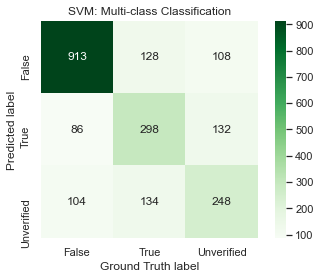

Accuracy:	0.678289
F1-score:	0.624659
Precision:	0.627470
Recall:		0.622694

 Classification performance:
              precision    recall  f1-score   support

       False       0.79      0.83      0.81      1103
        True       0.58      0.53      0.55       560
  Unverified       0.51      0.51      0.51       488

    accuracy                           0.68      2151
   macro avg       0.63      0.62      0.62      2151
weighted avg       0.67      0.68      0.68      2151



In [133]:
#Plot the confusion matrix 
mat4 = confusion_matrix(test_veracity, predicted_categories4)
sns.heatmap(mat4.T, square = True,xticklabels = ["False","True","Unverified"], yticklabels = ["False","True","Unverified"],annot=True, fmt = "d",cmap="Greens")
plt.xlabel("Ground Truth label")
plt.ylabel("Predicted label")
plt.title("SVM: Multi-class Classification")
#plt.savefig("ModeL 4- SVM 3 class.png")
plt.show()

# Compute and print classification performance metrics
print("Accuracy:\t%f" % accuracy_score(test_veracity, predicted_categories4))
print("F1-score:\t%f" % f1_score(test_veracity, predicted_categories4, average='macro'))
print("Precision:\t%f" % precision_score(test_veracity, predicted_categories4, average='macro'))
print("Recall:\t\t%f" % recall_score(test_veracity, predicted_categories4, average='macro'))

print("\n Classification performance:\n%s" % classification_report(test_veracity, predicted_categories4))


# Model 4- Decision Tree

In [51]:
model5 = make_pipeline(TfidfVectorizer(), tree.DecisionTreeClassifier())
model5.fit(train_text, train_veracity) # Train 

predicted_categories5 = model5.predict(test_text) # Predict 

print("Predicted Veracity:",predicted_categories5.tolist()[0:5]) # First 5 predictions
print("Ground truth Veracity:",test_veracity[0:5],"\n") # First 5 ground truth values


Predicted Veracity: ['False', 'False', 'False', 'False', 'False']
Ground truth Veracity: ['False', 'Unverified', 'False', 'False', 'False'] 



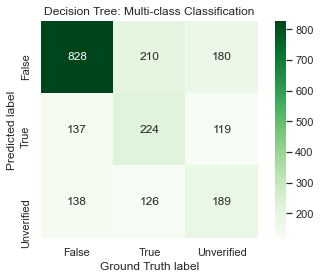

Accuracy:	0.576941
F1-score:	0.515318
Precision:	0.521229
Recall:		0.512658

 Classification performance:
              precision    recall  f1-score   support

       False       0.68      0.75      0.71      1103
        True       0.47      0.40      0.43       560
  Unverified       0.42      0.39      0.40       488

    accuracy                           0.58      2151
   macro avg       0.52      0.51      0.52      2151
weighted avg       0.56      0.58      0.57      2151



In [135]:
mat5 = confusion_matrix(test_veracity, predicted_categories5)
sns.heatmap(mat5.T, square = True,xticklabels = ["False","True","Unverified"], yticklabels = ["False","True","Unverified"],annot=True, fmt = "d",cmap="Greens")
plt.xlabel("Ground Truth label")
plt.ylabel("Predicted label")
plt.title("Decision Tree: Multi-class Classification")
#plt.savefig("Model 5- Decision Tree 3 class.png")
plt.show()

# Compute and print classification performance metrics
print("Accuracy:\t%f" % accuracy_score(test_veracity, predicted_categories5))
print("F1-score:\t%f" % f1_score(test_veracity, predicted_categories5, average='macro'))
print("Precision:\t%f" % precision_score(test_veracity, predicted_categories5, average='macro'))
print("Recall:\t\t%f" % recall_score(test_veracity, predicted_categories5, average='macro'))

print("\n Classification performance:\n%s" % classification_report(test_veracity, predicted_categories5))


# Model 6- Random Forest (100 Trees) 

In [53]:
model6 = make_pipeline(TfidfVectorizer(), RandomForestClassifier(n_estimators=100))
model6.fit(train_text, train_veracity) # Train 

predicted_categories6 = model6.predict(test_text) # Predict 

print("Predicted Veracity:",predicted_categories6.tolist()[0:5]) # First 5 predictions
print("Ground truth Veracity:",test_veracity[0:5],"\n") # First 5 ground truth values


Predicted Veracity: ['False', 'False', 'False', 'False', 'False']
Ground truth Veracity: ['False', 'Unverified', 'False', 'False', 'False'] 



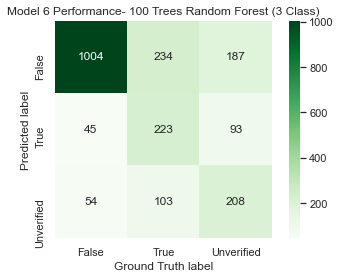

Accuracy:	0.667132
F1-score:	0.588750
Precision:	0.630718
Recall:		0.578230

 Classification performance:
              precision    recall  f1-score   support

       False       0.70      0.91      0.79      1103
        True       0.62      0.40      0.48       560
  Unverified       0.57      0.43      0.49       488

    accuracy                           0.67      2151
   macro avg       0.63      0.58      0.59      2151
weighted avg       0.65      0.67      0.64      2151



In [54]:
mat6 = confusion_matrix(test_veracity, predicted_categories6)
sns.heatmap(mat6.T, square = True,xticklabels = ["False","True","Unverified"], yticklabels = ["False","True","Unverified"],annot=True, fmt = "d",cmap="Greens")
plt.xlabel("Ground Truth label")
plt.ylabel("Predicted label")
plt.title("Model 6 Performance- 100 Trees Random Forest (3 Class)")
#plt.savefig("Model 6- 100 Random forest 3 class.png")
plt.show()

# Compute and print classification performance metrics
print("Accuracy:\t%f" % accuracy_score(test_veracity, predicted_categories6))
print("F1-score:\t%f" % f1_score(test_veracity, predicted_categories6, average='macro'))
print("Precision:\t%f" % precision_score(test_veracity, predicted_categories6, average='macro'))
print("Recall:\t\t%f" % recall_score(test_veracity, predicted_categories6, average='macro'))

print("\n Classification performance:\n%s" % classification_report(test_veracity, predicted_categories6))


# Model 5- Random Forest (1000) trees

In [57]:
model7 = make_pipeline(TfidfVectorizer(), RandomForestClassifier(n_estimators=1000))
model7.fit(train_text, train_veracity) # Train 

predicted_categories7 = model7.predict(test_text) # Predict

print("Predicted Veracity:",predicted_categories7.tolist()[0:5]) # First 5 predictions
print("Ground truth Veracity:",test_veracity[0:5],"\n") # First 5 ground truth values


Predicted Veracity: ['False', 'False', 'False', 'False', 'False']
Ground truth Veracity: ['False', 'Unverified', 'False', 'False', 'False'] 



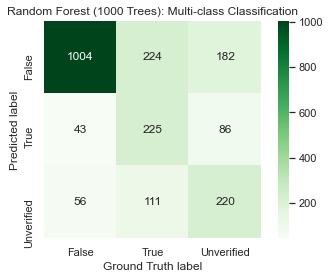

Accuracy:	0.673640
F1-score:	0.598081
Precision:	0.638708
Recall:		0.587617

 Classification performance:
              precision    recall  f1-score   support

       False       0.71      0.91      0.80      1103
        True       0.64      0.40      0.49       560
  Unverified       0.57      0.45      0.50       488

    accuracy                           0.67      2151
   macro avg       0.64      0.59      0.60      2151
weighted avg       0.66      0.67      0.65      2151



In [138]:
mat7 = confusion_matrix(test_veracity, predicted_categories7)
sns.heatmap(mat7.T, square = True,xticklabels = ["False","True","Unverified"], yticklabels = ["False","True","Unverified"],annot=True, fmt = "d",cmap="Greens")
plt.xlabel("Ground Truth label")
plt.ylabel("Predicted label")
plt.title("Random Forest (1000 Trees): Multi-class Classification")
#plt.savefig("Model 7- 1000 Random Forest 3 class.png")
plt.show()

# Compute and print classification performance metrics
print("Accuracy:\t%f" % accuracy_score(test_veracity, predicted_categories7))
print("F1-score:\t%f" % f1_score(test_veracity, predicted_categories7, average='macro'))
print("Precision:\t%f" % precision_score(test_veracity, predicted_categories7, average='macro'))
print("Recall:\t\t%f" % recall_score(test_veracity, predicted_categories7, average='macro'))

print("\n Classification performance:\n%s" % classification_report(test_veracity, predicted_categories7))


# Model 8- Neural Network LSTM

This model was formulated with guidance from Kasliwal, N. (2018). Natural Language Processing with Python Quick Start Guide (1st ed.). Van Haren Publishing

In [59]:
training_nn = pd.DataFrame({"Text":train_text, "Veracity":train_veracity})
training_nn.to_csv('training_nn.csv',index=False)
print(training_nn.head())

                                                Text    Veracity
0  break news wuhan coronavirus update amount peo...  Unverified
1  italy overwhelm hospitals treat elderly covid-...  Unverified
2  coronavirus could delay china five-g rollout t...  Unverified
3  map soul china army reach copy break mots pers...  Unverified
4  world grapple epidemic novel coronavirus gover...  Unverified


In [60]:
max_words = 0
for i in train_text:
    max_words = max(len(i.split()), max_words ) 

print(max_words) ##This shows the maximum number of words in a text, so we know the longest. 

83


In [61]:
import torch
import torchtext
from torchtext.legacy import data #For handling text data
import torch.nn as nn
import torch.optim as optim

In [62]:
#For LSTM, set it to include_lengths = False and fixed_lengths = True
TEXT = data.Field(tokenize=word_tokenize,batch_first=True,include_lengths=True)
LABEL = data.LabelField(dtype = torch.float, batch_first=True)
fields = [('text',TEXT),('label', LABEL)]
dataset = data.TabularDataset(path = "training_nn.csv", format = "csv", fields = fields, skip_header = True)


In [63]:
training_data, validation_data = dataset.split(split_ratio=0.7)

TEXT.build_vocab(training_data, min_freq = 1)
LABEL.build_vocab(training_data)

import torch.nn as nn

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Device:",device)
BatchSize = 32 # Bengio (2012) recommends 32
training_iterator, test_iterator = data.BucketIterator.splits(
    (training_data, validation_data),
    batch_size = BatchSize,
    sort_key = lambda x: len(x.text),
    sort_within_batch=True,
    device = device)

Device: cpu


In [64]:
print("Size of Text:",len(TEXT.vocab)) # Number of tokens in vocabulary
print("Size of Veracity:",len(LABEL.vocab),"\n") # Number of labels
print("Most common tokens:",TEXT.vocab.freqs.most_common(5),"\n") # Print the 5 most common in the training set

print("Number for unknown word:",TEXT.vocab.stoi['<unk>']) 
print("Number for padding word:",TEXT.vocab.stoi['<pad>'])

print("Number assigned to veracity:", LABEL.vocab.stoi) #Number assigned to veracity labels



Size of Text: 7411
Size of Veracity: 3 

Most common tokens: [('coronavirus', 2887), ('china', 1154), ('wuhan', 747), ('virus', 637), ('people', 617)] 

Number for unknown word: 0
Number for padding word: 1
Number assigned to veracity: defaultdict(None, {'Unverified': 0, 'False': 1, 'True': 2})


In [96]:
class LSTM(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers,
        bidirectional, dropout):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, 
                            hidden_dim, 
                            num_layers=n_layers, 
                            bidirectional=bidirectional, 
                            dropout=dropout, 
                            batch_first=True)
        self.fc1 = nn.Linear(hidden_dim * 2, output_dim)
    
    def forward(self, text, text_lengths):
        embedded = self.embedding(text)
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, text_lengths,batch_first=True)
        packed_output, (hidden, cell) = self.lstm(packed_embedded)
        hidden = torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1)
        dense_outputs=self.fc1(hidden)
        return dense_outputs
    
# Inputs
vocabulary_size = len(TEXT.vocab) #Length of vocab
embedding_dim = 100 # Embedding dimension of 100
LSTM_nodes =18 #18 hidden nodes
LSTM_layers = 2 # 2 layers
LSTM_bidirection = True
LSTM_dropout = 0.5
output = len(LABEL.vocab) #Output size is 3

# Create Model
LSTM_classification = LSTM(vocabulary_size, embedding_dim, LSTM_nodes,
    output, LSTM_layers,
    bidirectional = LSTM_bidirection,dropout = LSTM_dropout)

# Printing LSTM Model archiecture
print(LSTM_classification)

def parameters(model):
    return sum(p.numel() for p in LSTM_classification .parameters() if p.requires_grad)
print("\n The number of LSTM trainable parameters:",parameters(LSTM_classification))



LSTM(
  (embedding): Embedding(7411, 100)
  (lstm): LSTM(100, 18, num_layers=2, batch_first=True, dropout=0.5, bidirectional=True)
  (fc1): Linear(in_features=36, out_features=3, bias=True)
)

 The number of LSTM trainable parameters: 766555


In [97]:
optimizer = optim.Adam(LSTM_classification.parameters())
criterion = nn.CrossEntropyLoss()


def categorical_accuracy(preds, y):
    top_pred = preds.argmax(1, keepdim = True)
    correct = top_pred.eq(y.view_as(top_pred)).sum()
    acc = correct.float() / y.shape[0]
    return acc

LSTM_classification = LSTM_classification.to(device)
criterion = criterion.to(device)

def train(model, iterator, optimizer, criterion):
    epoch_loss = 0
    epoch_acc = 0
    model.train()
    for batch in iterator:
        optimizer.zero_grad()
        text, text_lengths = batch.text
        predictions = model(text, text_lengths).squeeze()
        loss = criterion(predictions, batch.label.type(torch.LongTensor)) # The label needs to be a LongTensors
        acc = categorical_accuracy(predictions, batch.label)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        epoch_acc += acc.item()
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

def evaluate(model, iterator, criterion):
    epoch_loss = 0
    epoch_acc = 0
    model.eval()
    with torch.no_grad():
        for batch in iterator:
            text, text_lengths = batch.text
            predictions = model(text, text_lengths).squeeze()
            loss = criterion(predictions, batch.label.type(torch.LongTensor))
            acc = categorical_accuracy(predictions, batch.label)
            epoch_loss += loss.item()
            epoch_acc += acc.item()
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [98]:
import time

Epochs = 6

# Training the model over 6 epochs
for epoch in range(Epochs):
    print("Epoch %3d:" % epoch,end='')
    start = time.time()
    train_loss, train_acc = train(LSTM_classification, training_iterator, optimizer, criterion)
    
    valid_loss, valid_acc = evaluate(LSTM_classification, test_iterator, criterion)
    print(" Train loss: %.3f | Train acuracy: %3.4f " % (train_loss,train_acc),end='')
    print("| Validation loss: %.3f | Validation acuracy: %3.4f" % (valid_loss,valid_acc),end='')
    print(" - %3.2f s" % (time.time()-start))



Epoch   0: Train loss: 1.084 | Train acuracy: 0.4075 | Validation loss: 1.035 | Validation acuracy: 0.5455 - 4.64 s
Epoch   1: Train loss: 0.892 | Train acuracy: 0.6080 | Validation loss: 0.798 | Validation acuracy: 0.6601 - 4.49 s
Epoch   2: Train loss: 0.638 | Train acuracy: 0.7483 | Validation loss: 0.675 | Validation acuracy: 0.7247 - 4.64 s
Epoch   3: Train loss: 0.445 | Train acuracy: 0.8372 | Validation loss: 0.627 | Validation acuracy: 0.7777 - 4.51 s
Epoch   4: Train loss: 0.323 | Train acuracy: 0.8856 | Validation loss: 0.601 | Validation acuracy: 0.8051 - 4.52 s
Epoch   5: Train loss: 0.242 | Train acuracy: 0.9173 | Validation loss: 0.612 | Validation acuracy: 0.8196 - 4.58 s


In [99]:
def LSTM_predict(model, sentence):
    tokenised = [token for token in word_tokenize(sentence)]
    indexed = [TEXT.vocab.stoi[token] for token in tokenised]
    length = [len(indexed)]
    tensor = torch.LongTensor(indexed).to(device)
    tensor = tensor.unsqueeze(1).T
    length_tensor = torch.LongTensor(length)
    prediction = model(tensor, length_tensor)
    prediction = prediction.argmax(dim = 1)
    return prediction.item()

label_names = {2:"True", 1:"False",0:"Unverified"}
#'Unverified': 0, 'False': 1, 'True': 2

prediction3 = []
for i in test_text:
    predict_label = label_names[LSTM_predict(LSTM_classification, i)]
    prediction3.append(predict_label)
    
print("Predicted Veracity:",prediction3[0:5])
print("Ground Truth Veracity:",test_veracity[0:5])

Predicted Veracity: ['False', 'False', 'False', 'True', 'False']
Ground Truth Veracity: ['False', 'Unverified', 'False', 'False', 'False']


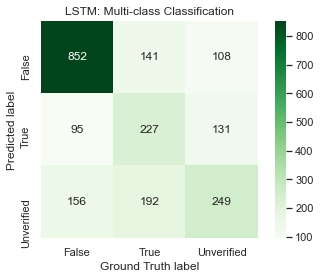

Accuracy:	0.617387
F1-score:	0.560100
Precision:	0.564010
Recall:		0.562681

 Classification performance:
              precision    recall  f1-score   support

       False       0.77      0.77      0.77      1103
        True       0.50      0.41      0.45       560
  Unverified       0.42      0.51      0.46       488

    accuracy                           0.62      2151
   macro avg       0.56      0.56      0.56      2151
weighted avg       0.62      0.62      0.62      2151



In [139]:
mat8 = confusion_matrix(test_veracity, prediction3)
sns.heatmap(mat8.T, square = True,xticklabels = ["False","True","Unverified"], yticklabels = ["False","True","Unverified"], annot=True, fmt = "d",cmap="Greens")

plt.xlabel("Ground Truth label")
plt.ylabel("Predicted label")
plt.title("LSTM: Multi-class Classification")
#plt.savefig("Model 8- LSTM 3 class.png")
plt.show()

# Compute and print classification performance metrics
print("Accuracy:\t%f" % accuracy_score(test_veracity, prediction3))
print("F1-score:\t%f" % f1_score(test_veracity, prediction3, average='macro'))
print("Precision:\t%f" % precision_score(test_veracity, prediction3, average='macro'))
print("Recall:\t\t%f" % recall_score(test_veracity, prediction3, average='macro'))

print("\n Classification performance:\n%s" % classification_report(test_veracity, prediction3))


# Model 9- CNN

Model guided by Trevett, B. (2021). pytorch-sentiment-analysis/4 - Convolutional Sentiment Analysis.ipynb at master · bentrevett/pytorch-sentiment-analysis. GitHub. Retrieved 20 May 2022, from https://github.com/bentrevett/pytorch-sentiment-analysis/blob/master/4%20-%20Convolutional%20Sentiment%20Analysis.ipynb

In [101]:
max_words = 0
for sentence in train_text :
    max_words = max(len(sentence.split()), max_words ) 

print(max_words) #48 Words

83


In [102]:
# For CNN, using the argument fix_length which is the maximum sentence length
# for padding purposes.
TEXT = data.Field(tokenize=word_tokenize,batch_first=True, fix_length = max_words)
LABEL = data.LabelField(dtype = torch.float, batch_first=True)
fields = [('text',TEXT),('label', LABEL)]
dataset = data.TabularDataset(path = "training_nn.csv", format = "csv", fields = fields, skip_header = True)


In [103]:
training_data, validation_data = dataset.split(split_ratio=0.7)

TEXT.build_vocab(training_data, min_freq = 1)
LABEL.build_vocab(training_data)


In [104]:
print("Size of text vocabulary:",len(TEXT.vocab)) 
print("Size of label vocabulary:",len(LABEL.vocab),"\n") 
print("Most common tokens:",TEXT.vocab.freqs.most_common(5),"\n")

print("Number for unknown word :",TEXT.vocab.stoi['<unk>']) 
print("Number for padding word :",TEXT.vocab.stoi['<pad>'])
#Print the lablel keys which are needed later when predicting.
print("Veracity labels:", LABEL.vocab.stoi)

Size of text vocabulary: 7411
Size of label vocabulary: 3 

Most common tokens: [('coronavirus', 2887), ('china', 1154), ('wuhan', 747), ('virus', 637), ('people', 617)] 

Number for unknown word : 0
Number for padding word : 1
Veracity labels: defaultdict(None, {'Unverified': 0, 'False': 1, 'True': 2})


In [105]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Device:",device)
BatchSize = 32
training_iterator, test_iterator = data.BucketIterator.splits(
    (training_data, validation_data),
    batch_size = BatchSize,
    sort_key = lambda x: len(x.text),
    sort_within_batch=True,
    device = device)

Device: cpu


In [118]:
class CNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim, output_dim, n_filters,
                filter_sizes, max_length, pad_idx, dropout):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx = pad_idx)
        
        self.conv_layers = nn.ModuleList([
            nn.Conv1d(in_channels = embedding_dim, out_channels = n_filters,
                      kernel_size = f, padding = 'same') for f in filter_sizes])
        
        self.maxpool1d = nn.MaxPool1d(2, stride = 2)
        
        self.fc = nn.Linear(len(filter_sizes) * n_filters*82//2,output_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, text):
        embedded = self.embedding(text)
        embedded = embedded.permute(0,2,1)
        conved = [F.relu(conv(embedded)) for conv in self.conv_layers]
        pooled = [self.maxpool1d(cons) for cons in conved]
        cat = torch.cat(pooled, dim = 1)
        flat = torch.flatten(cat, start_dim = 1)
        drop = self.dropout(flat)
        return self.fc(drop)
        
# Inputs
vocab_size = len(TEXT.vocab) # Length of Vocab
embedding_dim = 100 # Embedding Dimension of 100
output = len(LABEL.vocab) #Output size is 3
n_filters = 100
filter_sizes = [2,3,4] #Bi-gram, Tri-gram and Four-gram
max_length = 83 # 83 is the maximum word length
pad_idx = TEXT.vocab.stoi[TEXT.pad_token] #Padding index token = 1
dropout = 0.5 #Dropout rate of 0.5
    
CNN_classification = CNN(vocab_size, 
            embedding_dim,
            output,
            n_filters,
            filter_sizes,
            max_length,
            pad_idx,
            dropout)

#Printing the model architecture
print(CNN_classification)
def parameters(model):
    return sum(p.numel() for p in CNN_classification.parameters() if p.requires_grad)
print("\n CNN model trainable parameters:",parameters(CNN_classification))


CNN(
  (embedding): Embedding(7411, 100, padding_idx=1)
  (conv_layers): ModuleList(
    (0): Conv1d(100, 100, kernel_size=(2,), stride=(1,), padding=same)
    (1): Conv1d(100, 100, kernel_size=(3,), stride=(1,), padding=same)
    (2): Conv1d(100, 100, kernel_size=(4,), stride=(1,), padding=same)
  )
  (maxpool1d): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc): Linear(in_features=12300, out_features=3, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)

 CNN model trainable parameters: 868303


In [119]:
optimizer = torch.optim.Adam(CNN_classification.parameters()) 
criterion  = nn.CrossEntropyLoss() # Use cross entropy loss as loss fucntion

def categorical_accuracy(preds, y):
    top_pred = preds.argmax(1, keepdim = True)
    correct = top_pred.eq(y.view_as(top_pred)).sum()
    acc = correct.float() / y.shape[0]
    return acc

CNN_classification = CNN_classification.to(device)
criterion = criterion.to(device)

In [120]:
def train(model, iterator, optimizer, criterion):
    epoch_loss = 0
    epoch_acc = 0
    model.train()
    for batch in iterator:
        optimizer.zero_grad()
        text= batch.text # Retrieve text and number of words 
        predictions = model(text).squeeze() 
        loss = criterion(predictions, batch.label.type(torch.LongTensor))
        acc = categorical_accuracy(predictions, batch.label)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        epoch_acc += acc.item()
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

def evaluate(model, iterator, criterion):
    epoch_loss = 0
    epoch_acc = 0
    model.eval()
    with torch.no_grad():
        for batch in iterator:
            text = batch.text # Retrieve text and number of words 
            predictions = model(text).squeeze()
            loss = criterion(predictions, batch.label.type(torch.LongTensor))
            acc = categorical_accuracy(predictions, batch.label)
            epoch_loss += loss.item()
            epoch_acc += acc.item()
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

import time

Epochs = 6 # 6 epochs

for epoch in range(Epochs):
    print("Epoch %3d:" % epoch,end='')
    start = time.time()
    train_loss, train_acc = train(CNN_classification, training_iterator, optimizer, criterion)
    
    valid_loss, valid_acc = evaluate(CNN_classification, test_iterator, criterion)

    print(" Train loss: %.3f | Train acuracy: %3.4f " % (train_loss,train_acc),end='')
    print("| Validation loss: %.3f | Validation acuracy: %3.4f" % (valid_loss,valid_acc),end='')
    print(" - %3.2f s" % (time.time()-start))



Epoch   0: Train loss: 0.992 | Train acuracy: 0.5105 | Validation loss: 0.788 | Validation acuracy: 0.6804 - 13.06 s
Epoch   1: Train loss: 0.617 | Train acuracy: 0.7637 | Validation loss: 0.695 | Validation acuracy: 0.7600 - 13.19 s
Epoch   2: Train loss: 0.384 | Train acuracy: 0.8605 | Validation loss: 0.528 | Validation acuracy: 0.8111 - 13.11 s
Epoch   3: Train loss: 0.229 | Train acuracy: 0.9242 | Validation loss: 0.537 | Validation acuracy: 0.8258 - 12.92 s
Epoch   4: Train loss: 0.148 | Train acuracy: 0.9549 | Validation loss: 0.582 | Validation acuracy: 0.8269 - 13.12 s
Epoch   5: Train loss: 0.110 | Train acuracy: 0.9658 | Validation loss: 0.552 | Validation acuracy: 0.8430 - 12.93 s


In [121]:
def predict_CNN(model, sentence, min_len = max_words):
    tokenised = [token for token in word_tokenize(sentence)] # Tokenise text
    if len(tokenised) < min_len:
        tokenised+= ['<pad>'] * (min_len - len(tokenised))
    
    indexed = [TEXT.vocab.stoi[token] for token in tokenised] 
    tensor = torch.LongTensor(indexed).to(device)
    tensor = tensor.unsqueeze(0)
    prediction = model(tensor)
    prediction = prediction.argmax(dim = 1)
    return int(round(prediction.item()))

# Ensuring labels for neurals match up with the correct labels to predict sentiment
label_names = {2:'True',1:'False', 0:'Unverified'}
#{'Unverified': 0, 'False': 1, 'True': 2})

prediction9 = []

for i in test_text:
    predict_label = label_names[predict_CNN(CNN_classification, i)]
    prediction9.append(predict_label)
    
print("Predicted Veracity:",prediction9[0:5])
print("Ground Truth Veracity:",test_veracity[0:5])


Predicted Veracity: ['False', 'False', 'False', 'False', 'False']
Ground Truth Veracity: ['False', 'Unverified', 'False', 'False', 'False']


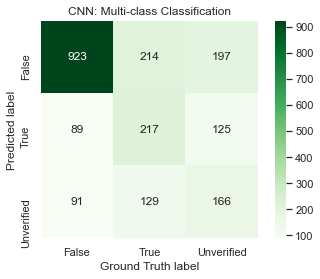

Accuracy:	0.607159
F1-score:	0.525098
Precision:	0.541812
Recall:		0.521491

 Classification performance:
              precision    recall  f1-score   support

       False       0.69      0.84      0.76      1103
        True       0.50      0.39      0.44       560
  Unverified       0.43      0.34      0.38       488

    accuracy                           0.61      2151
   macro avg       0.54      0.52      0.53      2151
weighted avg       0.58      0.61      0.59      2151



In [141]:
mat9 = confusion_matrix(test_veracity, prediction9)
sns.heatmap(mat9.T, square = True ,xticklabels = ["False","True","Unverified"], yticklabels = ["False","True","Unverified"], annot=True, fmt = "d",cmap="Greens")

plt.xlabel("Ground Truth label")
plt.ylabel("Predicted label")
plt.title("CNN: Multi-class Classification")
#plt.savefig("Model 9- CNN 3 class.png")
plt.show()

# Compute and print classification performance metrics
print("Accuracy:\t%f" % accuracy_score(test_veracity, prediction9))
print("F1-score:\t%f" % f1_score(test_veracity, prediction9, average='macro'))
print("Precision:\t%f" % precision_score(test_veracity, prediction9, average='macro'))
print("Recall:\t\t%f" % recall_score(test_veracity, prediction9, average='macro'))

print("\n Classification performance:\n%s" % classification_report(test_veracity, prediction9))
